# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
In an ever more electrified world, power outages have a greater impact on peoples' lives than ever before. For some people with battery electric vehicles a power outage can mean being trapped at home. With temperatures and the rate of extreme weather events on the rise due to global warming, power outages are and will continue to become more detrimental and dangerous to people's well being. Power outages and their causes need more scrutiny than ever. This project aims to do preliminary explorations into the trends and causes of power outages in the United States. Specifically it aims to answer the question- Is there a link between population of an area and the number of power outages the area experiences? There is a possibility areas with higher populations might have better power coverage and quality service because of market pressures compared to less populous areas which have fewer customers for power. Conversely, it is also possible areas with higher populations could experience more strain and load on their local power grids increasing the risk of power outages compared to less populous areas which may use less electricity.

### Cleaning and EDA
While reading in the data, the majority of features were dropped as they were outside the scope of the investigation and all instances of missing value placeholder "NA" were replaced with NaN to assist later analysis. Both outage start and outage restoration were combined into a single column each from their respective date and time columns. EDA began with plotting the distributions of outage months and outage durations. A higher proportion of outages occured in the summer months with a smaller spike in the coldest winter months- this is could be due to the extreme weather necessitating increased heater/AC use around that time. Additionally in 75% of observations, power was restored within 48 hours and for about 50% of observations power was restored within 12 hours. While plotting outage counts by state and population, a visual correlation between population and outage count was discovered. Plotting population versus outage count revealed further possible correlation graphically. A regression test later revealed a high R-Squared value. 

### Assessment of Missingness
To investigate missingness, first the missing columns were found and isolated. Then each column with missing values was compared to each column with missing values (apart from themselves). The MONTH, CLIMATE.REGION, ANOMALY.LEVEL,CLIMATE.CATEGORY, OUTAGE.START, OUTAGE.RESTORATION, and OUTAGE.DURATION columns were found to be completely linked with any missingness in any one of these columns guaranteeing missing values in the rest of the columns. This is likely a result of the data collection process and now statistically significant connection to other columns was found with these columns. However with the missingness of the CLIMATE.REGION and DEMAND.LOSS a low p valu and hence implying being related. However, after permutation testing a statistically significant difference between the variables was not found.

### Hypothesis Test
During EDA, it was found that there could be a link between population and power outage count. To investigate this further, the dataset was binned and then aggregated into 10 bins of state populations. The null hypothesis was that power outages occur at the same frequency across different population quantiles with the alternative hypothesis positing power outages occur at different frequencies based on population. After running a permutation test using TVD as the test statistic, the test failed to reject the null at a P-value of 0.9105. While this is surprising given the previous results during EDA further resolution is needed as this test was done at the state population level. Future study would benefit greatly from county level information on power outages to provide more clarity and more differentiation as states are very homogenous relative to the county level.

# Code

In [287]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import patsy
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import folium
import scipy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Reading Data

### Cleaning and EDA

#### Initializing Dataset for Analysis



In [288]:
outage = pd.read_excel(
                io='data/outage.xlsx',
                index_col=0,
                header=5,
                usecols=list(range(1,57)),
                skiprows=[6]
                )

#Replacing NA with NAN
outage.replace(to_replace='NA',value = np.NaN, inplace=True)

#Converting outage start and restoration date/time columns into single column
out_st_dt=outage['OUTAGE.START.DATE'].astype(np.datetime64)
out_st_tm=outage['OUTAGE.START.TIME'].astype(str).astype(np.datetime64).dt.time
out_st = (
    out_st_dt.astype(str)+' '+out_st_tm.astype(str)
        ).replace('NaT NaT',np.NaN).astype(np.datetime64)

rst_dt=outage['OUTAGE.RESTORATION.DATE'].astype(np.datetime64)
rst_tm=\
    outage['OUTAGE.RESTORATION.TIME'].astype(str).astype(np.datetime64).dt.time
rst =  (
        rst_dt.astype(str)+' '+rst_tm.astype(str)
        ).replace('NaT NaT',np.NaN).astype(np.datetime64)

outage.insert(8, 'OUTAGE.START', out_st)
outage.insert(9, 'OUTAGE.RESTORATION', rst)

#Primary features selected for analysis

keeps = [
        'YEAR', 
        'MONTH',
        'POSTAL.CODE',
        'OUTAGE.START',
        'OUTAGE.RESTORATION',
        'NERC.REGION',
        'CLIMATE.REGION',
        'ANOMALY.LEVEL',
        'CLIMATE.CATEGORY',
        'OUTAGE.DURATION',
        'DEMAND.LOSS.MW',
        'CUSTOMERS.AFFECTED',
        'PC.REALGSP.STATE',
        'PC.REALGSP.REL',
        'POPULATION'
        ]

drops = [col for col in outage.columns if col not in keeps]

#Redundant Features
drops+= [
        'OUTAGE.START.DATE', 
        'OUTAGE.START.TIME', 
        'OUTAGE.RESTORATION.DATE', 
        'OUTAGE.RESTORATION.TIME',
        ]

outage.drop(columns=drops, inplace=True)

outage.head()

,YEAR,MONTH,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,PC.REALGSP.STATE,PC.REALGSP.REL,POPULATION
OBS,,,,,,,,,,,,,,,
1,2011,7.0,MN,MRO,East North Central,-0.3,normal,2011-07-01 17:00:00,2011-07-03 20:00:00,3060.0,NaN,70000.0,51268,1.077376,5348119
2,2014,5.0,MN,MRO,East North Central,-0.1,normal,2014-05-11 18:38:00,2014-05-11 18:39:00,1.0,NaN,NaN,53499,1.089792,5457125
3,2010,10.0,MN,MRO,East North Central,-1.5,cold,2010-10-26 20:00:00,2010-10-28 22:00:00,3000.0,NaN,70000.0,50447,1.066826,5310903
4,2012,6.0,MN,MRO,East North Central,-0.1,normal,2012-06-19 04:30:00,2012-06-20 23:00:00,2550.0,NaN,68200.0,51598,1.071476,5380443
5,2015,7.0,MN,MRO,East North Central,1.2,warm,2015-07-18 02:00:00,2015-07-19 07:00:00,1740.0,250.0,250000.0,54431,1.092027,5489594


#### EDA

In [289]:
outage.describe()

,YEAR,MONTH,ANOMALY.LEVEL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,PC.REALGSP.STATE,PC.REALGSP.REL,POPULATION
count,1534.000000,1525.000000,1525.000000,1476.000000,829.000000,1.091000e+03,1534.000000,1534.000000,1.534000e+03
mean,2010.119296,6.234754,-0.096852,2625.398374,536.287093,1.434562e+05,49390.122555,1.027398,1.319400e+07
std,3.822306,3.254510,0.739957,5942.483307,2196.450393,2.869863e+05,11687.434002,0.243466,1.155396e+07
min,2000.000000,1.000000,-1.600000,0.000000,0.000000,0.000000e+00,31111.000000,0.639876,5.598510e+05
25%,2008.000000,4.000000,-0.500000,102.250000,3.000000,9.650000e+03,43056.000000,0.893561,5.310903e+06
50%,2011.000000,6.000000,-0.300000,701.000000,168.000000,7.013500e+04,48370.000000,1.021204,8.769252e+06
75%,2013.000000,9.000000,0.300000,2880.000000,400.000000,1.500000e+05,53622.000000,1.110032,1.940292e+07
max,2016.000000,12.000000,2.300000,108653.000000,41788.000000,3.241437e+06,168377.000000,3.560746,3.929648e+07


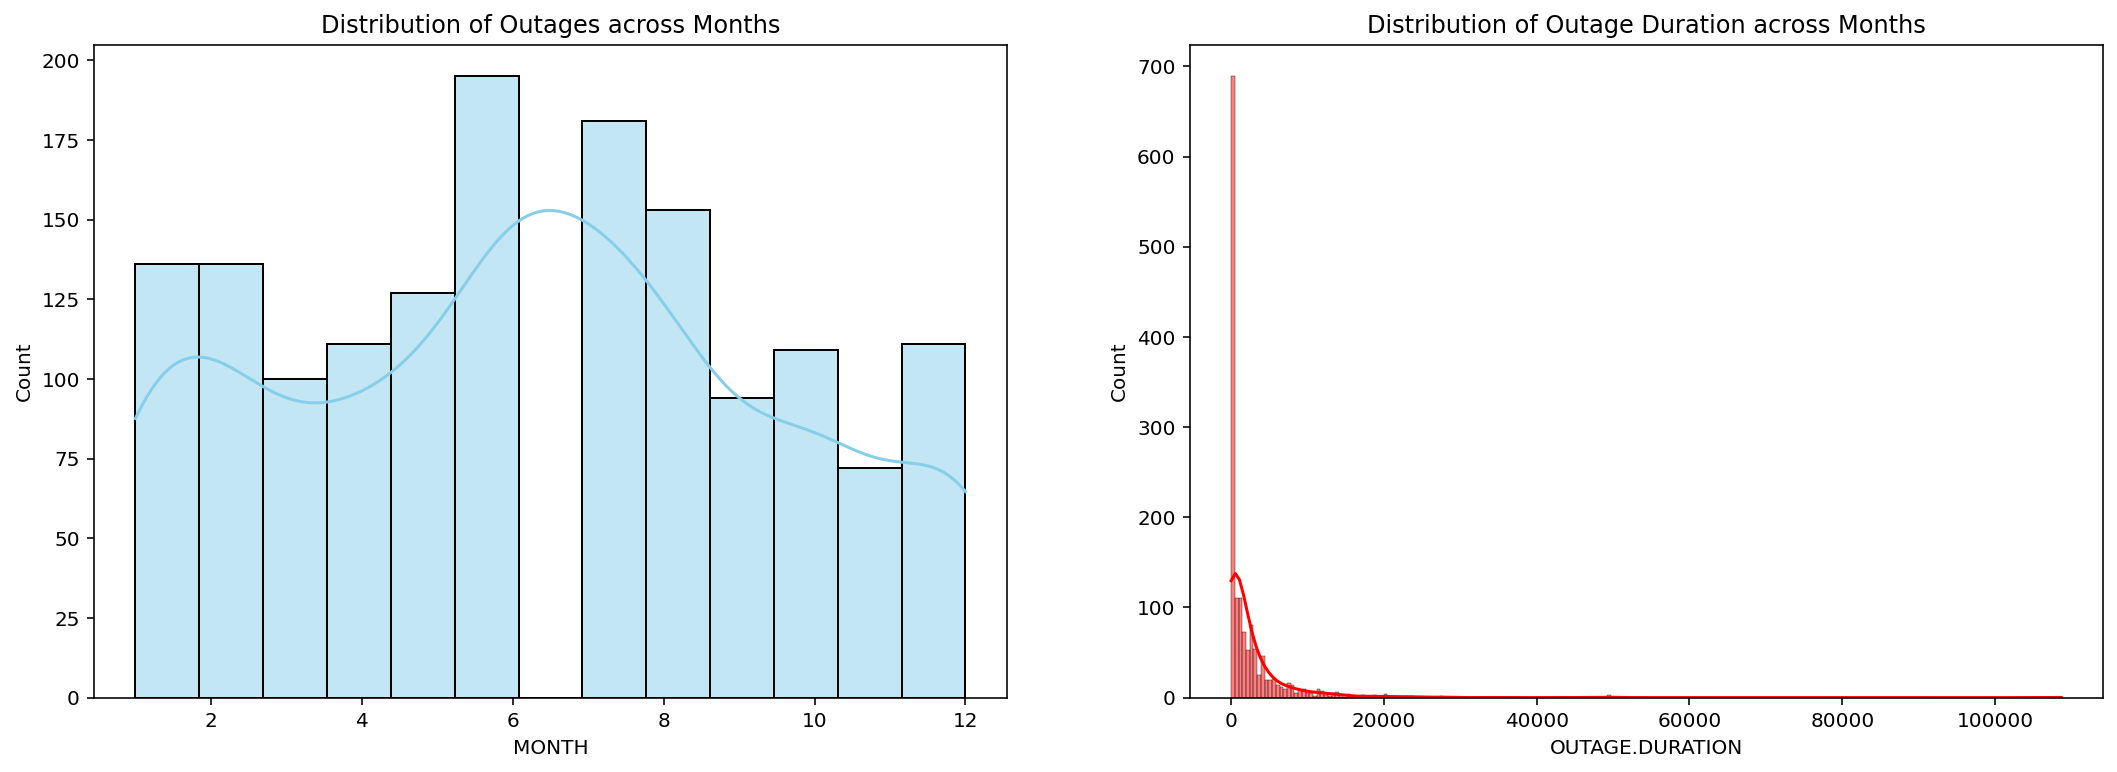

In [290]:
subset_outage = outage[[
                        'YEAR',
                        'MONTH',
                        'OUTAGE.DURATION',
                        'DEMAND.LOSS.MW',
                        'PC.REALGSP.STATE',
                        'POPULATION'
                        ]]

f, axes = plt.subplots(1, 2, figsize=(18,6))

month = sns.histplot(
                data=subset_outage,
                x="MONTH",
                ax=axes[0],
                color="skyblue",
                kde=True,
                    ).set(title="Distribution of Outages across Months")

month = sns.histplot(
                data=subset_outage,
                x="OUTAGE.DURATION",
                ax=axes[1],
                color="red",
                kde=True
                    ).set(title="Distribution of Outage Duration across Months")

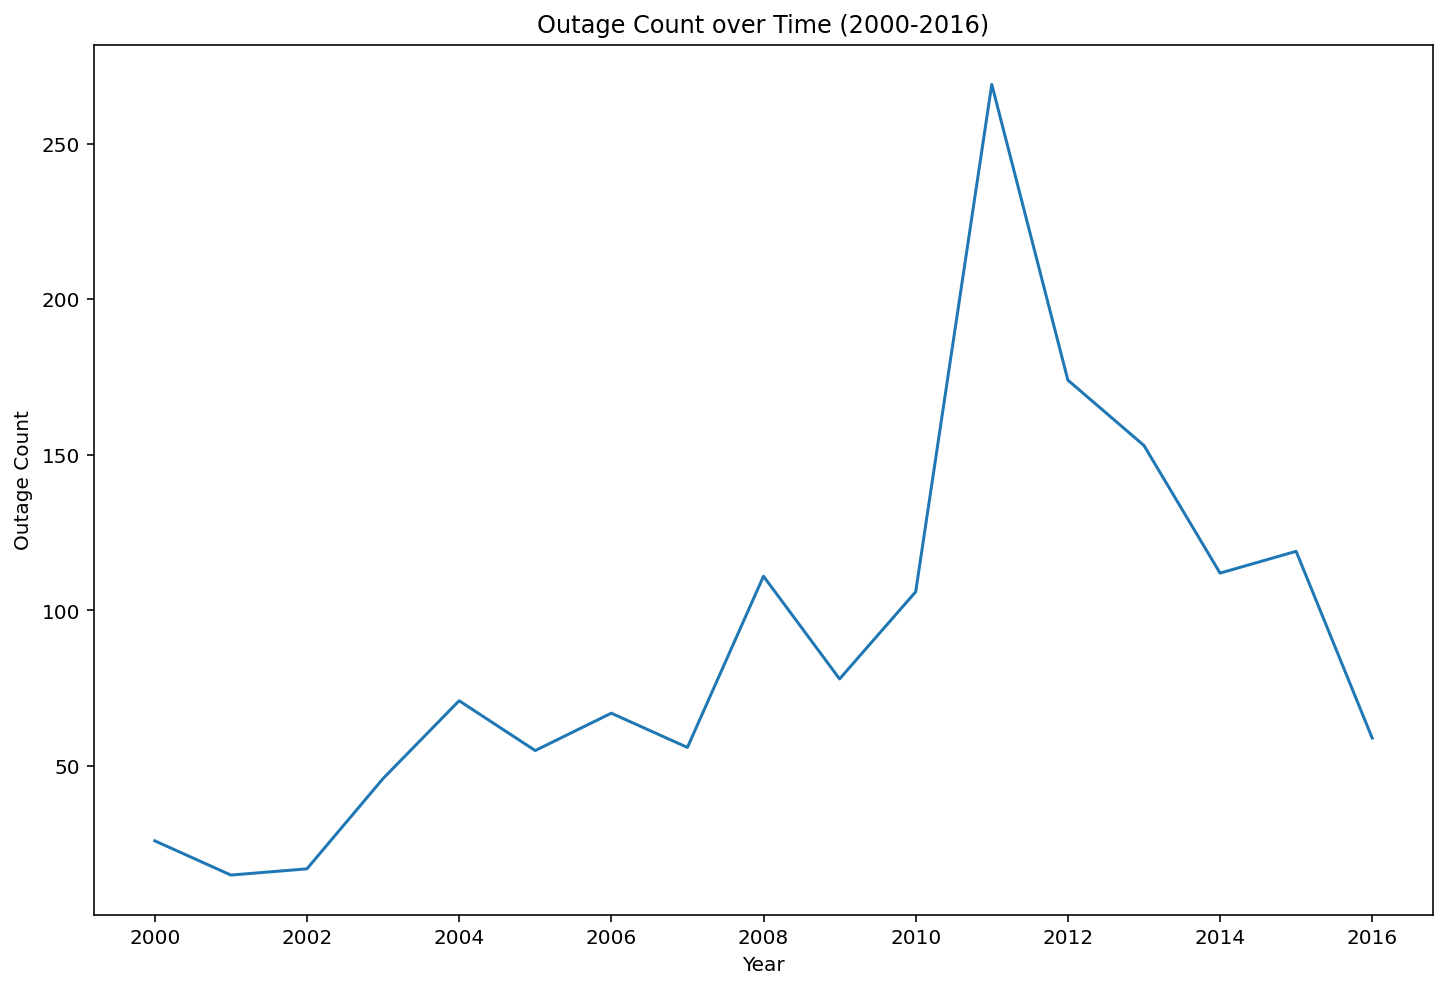

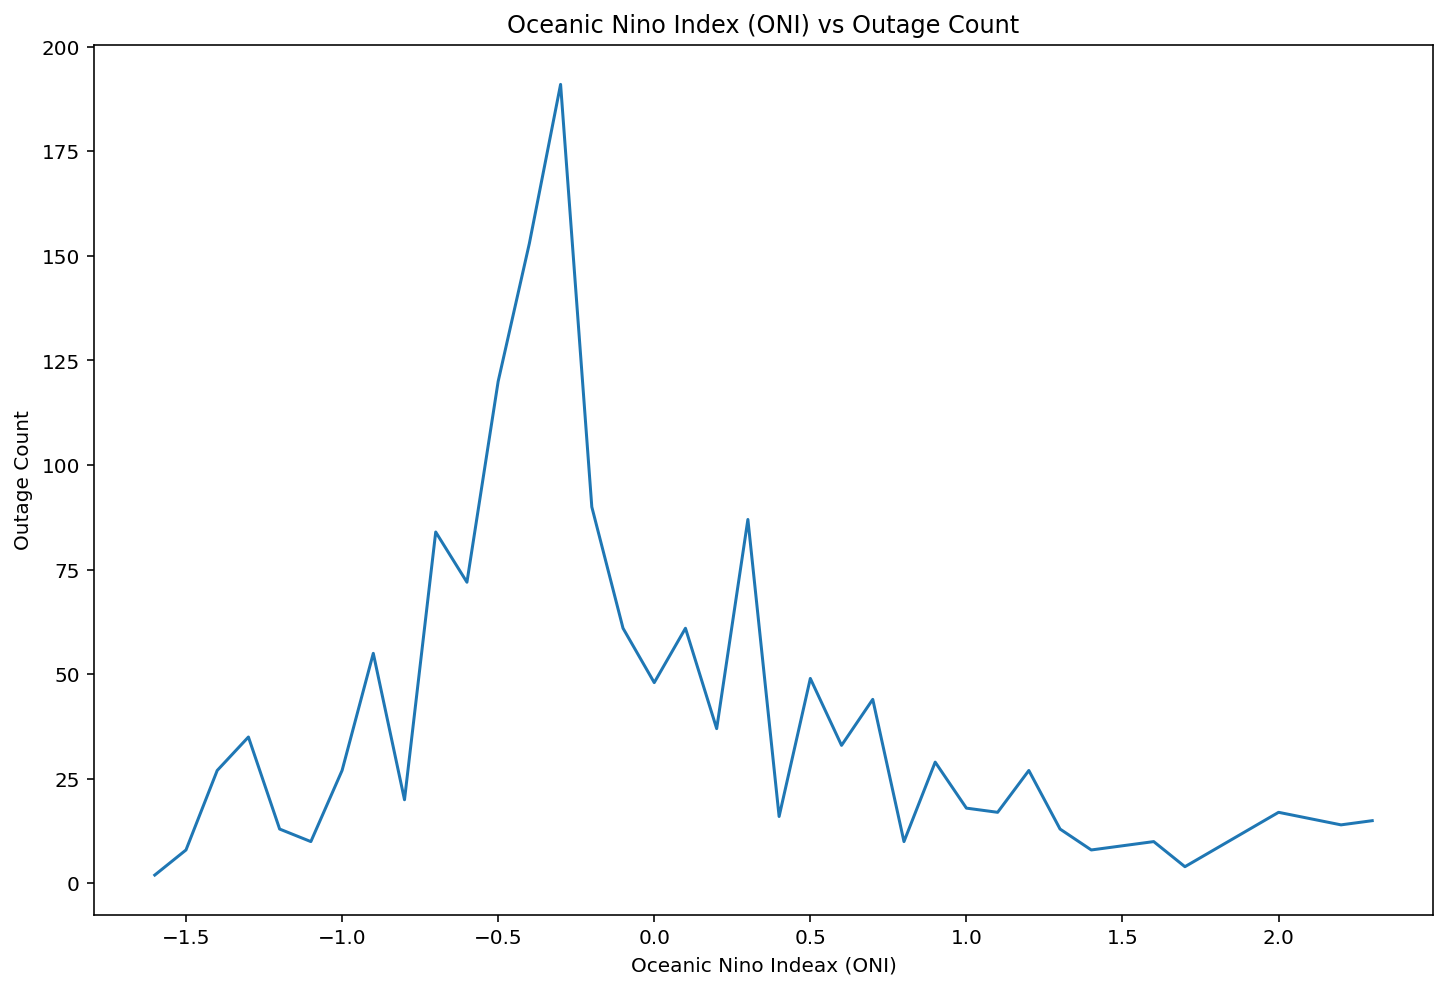

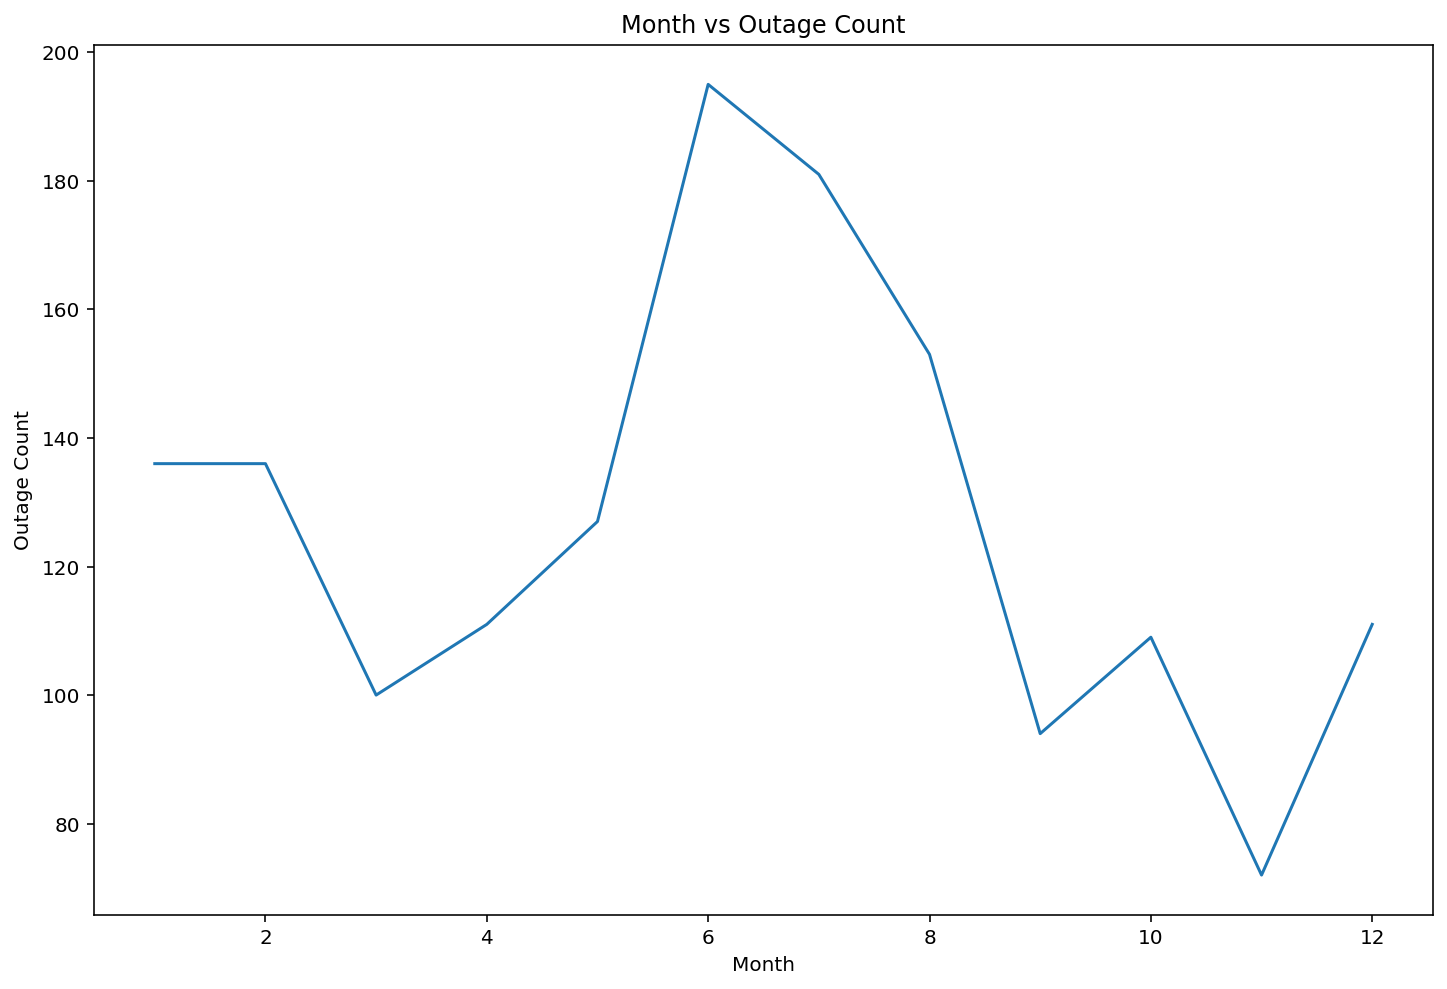

In [291]:
outage_ct_yr = outage.groupby('YEAR').count()['POSTAL.CODE'].reset_index()
outage_ct_yr.rename(
            columns= {'YEAR':'Year','POSTAL.CODE':'Outage Count'},
            inplace=True
                    )

outage_ct_oni = \
    outage.groupby('ANOMALY.LEVEL').count()['POSTAL.CODE'].reset_index()
outage_ct_oni.rename(
            columns= {
                'ANOMALY.LEVEL':'Oceanic Nino Indeax (ONI)',
                'POSTAL.CODE':'Outage Count'},
            inplace=True
                    )

outage_ct_month = \
    outage.groupby('MONTH').count()['POSTAL.CODE'].reset_index()
outage_ct_month.rename(
            columns= {
                'MONTH':'Month',
                'POSTAL.CODE':'Outage Count'},
            inplace=True
                    )

plt.figure(figsize=(12, 8))
sb_line = sns.lineplot(
    data=outage_ct_yr,
    x= "Year",
    y='Outage Count',
    ).set(title = "Outage Count over Time (2000-2016)")

plt.figure(figsize=(12, 8))
sb_line = sns.lineplot(
    data=outage_ct_oni,
    x="Oceanic Nino Indeax (ONI)",
    y='Outage Count',
    ).set(title = "Oceanic Nino Index (ONI) vs Outage Count")

plt.figure(figsize=(12, 8))
sb_line = sns.lineplot(
    data=outage_ct_month,
    x="Month",
    y='Outage Count',
    ).set(title = "Month vs Outage Count")


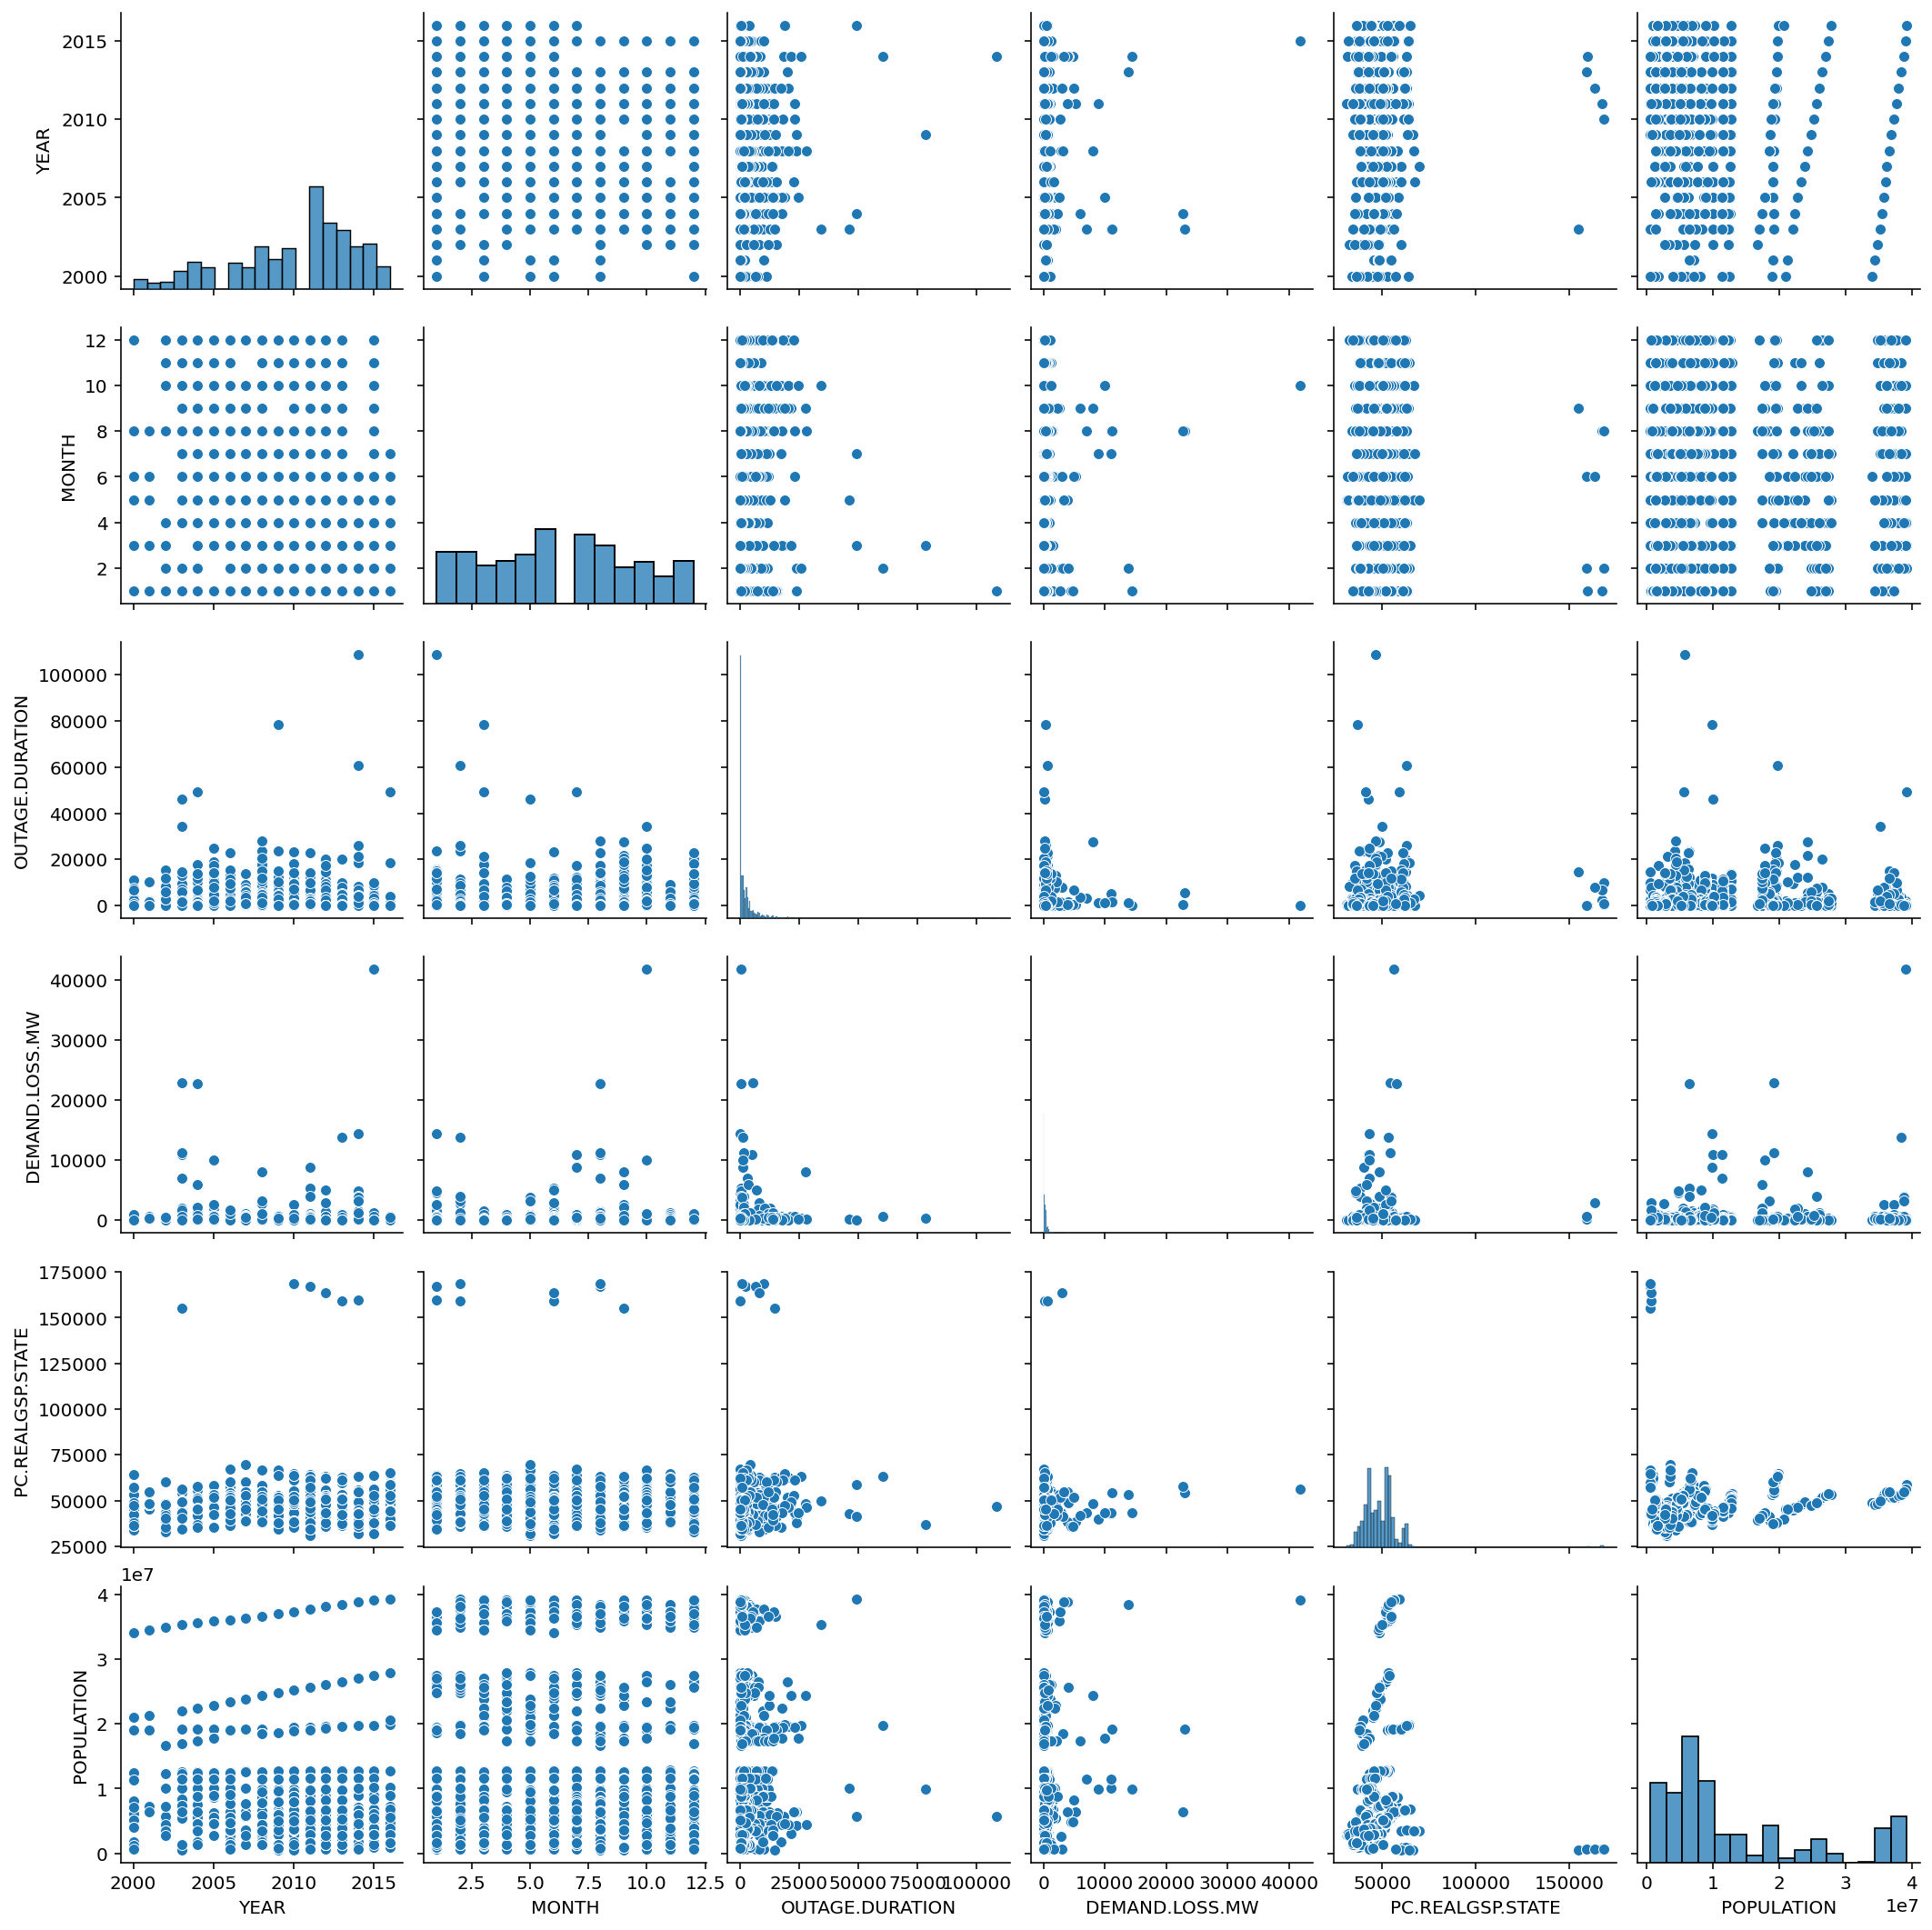

In [292]:
sns.pairplot(data= subset_outage)

In [293]:
by_state = outage.groupby('POSTAL.CODE').count()['YEAR'].reset_index()
by_state[['State', 'Outage_Num']] = by_state[['POSTAL.CODE', 'YEAR']]
by_state.drop(columns= ['POSTAL.CODE', 'YEAR'], inplace=True)
by_state = by_state[by_state['State'] != 'DC']
by_state.loc[len(by_state.index)+1] = ['RI', np.NaN]
pop = outage[['POSTAL.CODE','POPULATION','PC.REALGSP.STATE']].groupby('POSTAL.CODE').max().reset_index()
pop.loc[len(by_state.index)+1] = ['RI', np.NaN, np.NaN]
by_state['Population'] = pop['POPULATION']/1000000
by_state['State_GSP_PC'] = pop['PC.REALGSP.STATE']/1000
by_state

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

outage_map = folium.Map(
    location=[40, -95], 
    zoom_start=4, 
    no_wrap=True, 
    max_bounds=True
    )

folium.Choropleth(
    geo_data=state_geo,
    name="Outages",
    data=by_state,
    columns=["State", "Outage_Num"],
    key_on="feature.id",
    fill_color="OrRd",
    fill_opacity=0.6,
    line_opacity=.1,
    legend_name="Number of Outages",
    Highlight= True,
).add_to(outage_map)


folium.Choropleth(
    geo_data=state_geo,
    name="Population",
    data=by_state,
    columns=["State", "Population"],
    key_on="feature.id",
    fill_color="Greys",
    fill_opacity=0.6,
    line_opacity=.1,
    legend_name="Population (M)",
    Highlight= True,
).add_to(outage_map)

folium.Choropleth(
    geo_data=state_geo,
    name="GSP Per Capita",
    data=by_state,
    columns=["State", "State_GSP_PC"],
    key_on="feature.id",
    fill_color="RdYlGn",
    fill_opacity=0.6,
    line_opacity=.1,
    legend_name="GSP per Capita in USD (K)",
    Highlight= True,
).add_to(outage_map)

outage_map.add_child(folium.LayerControl())

outage_map

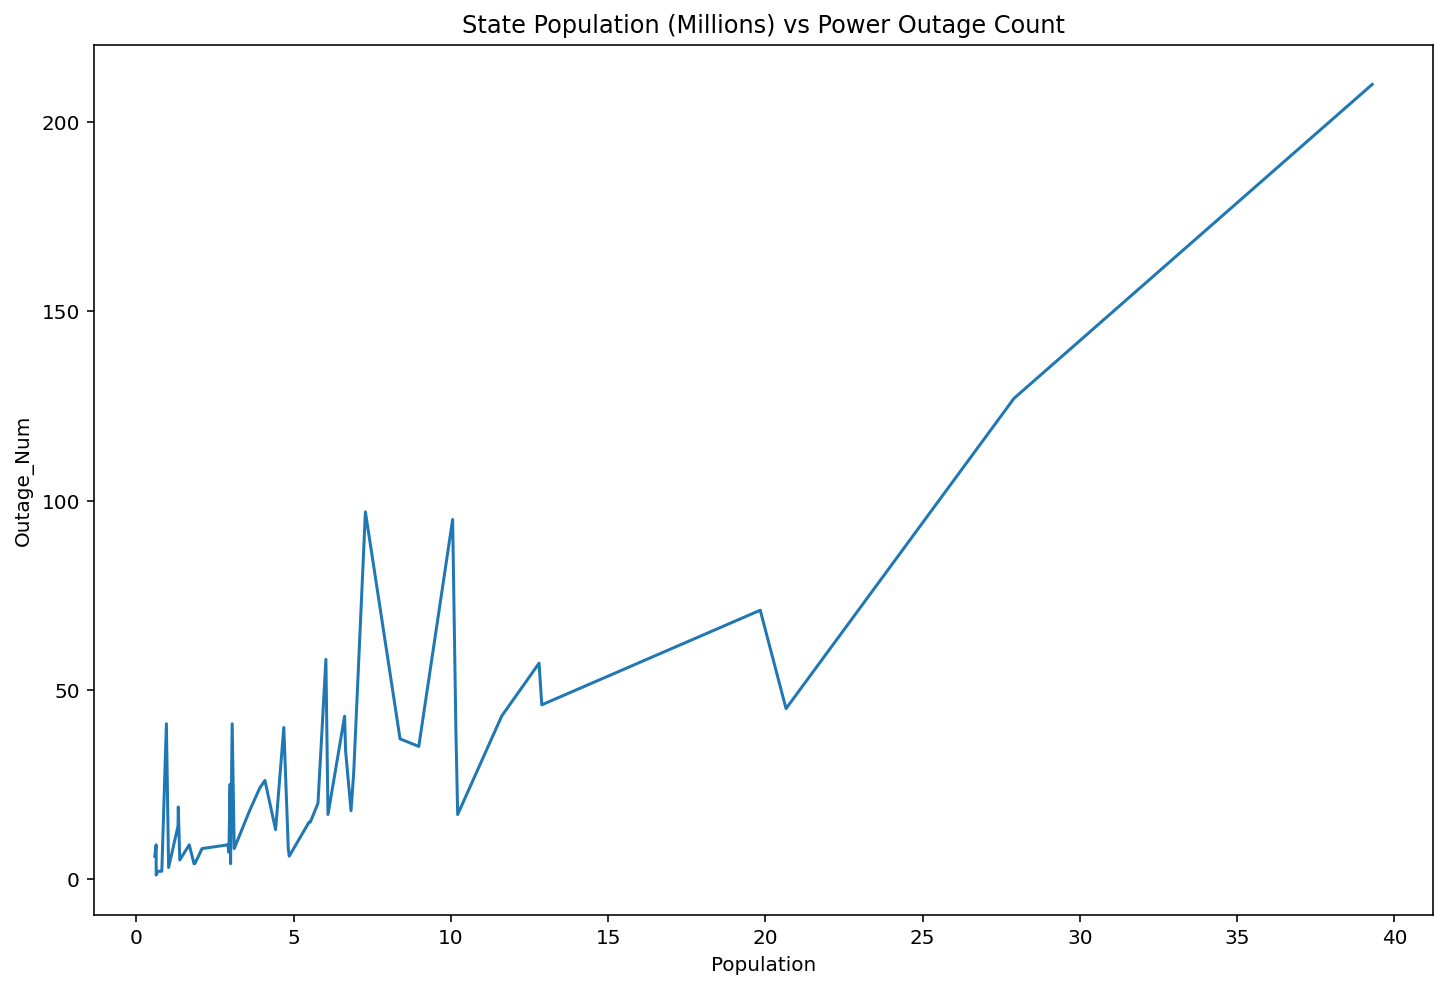

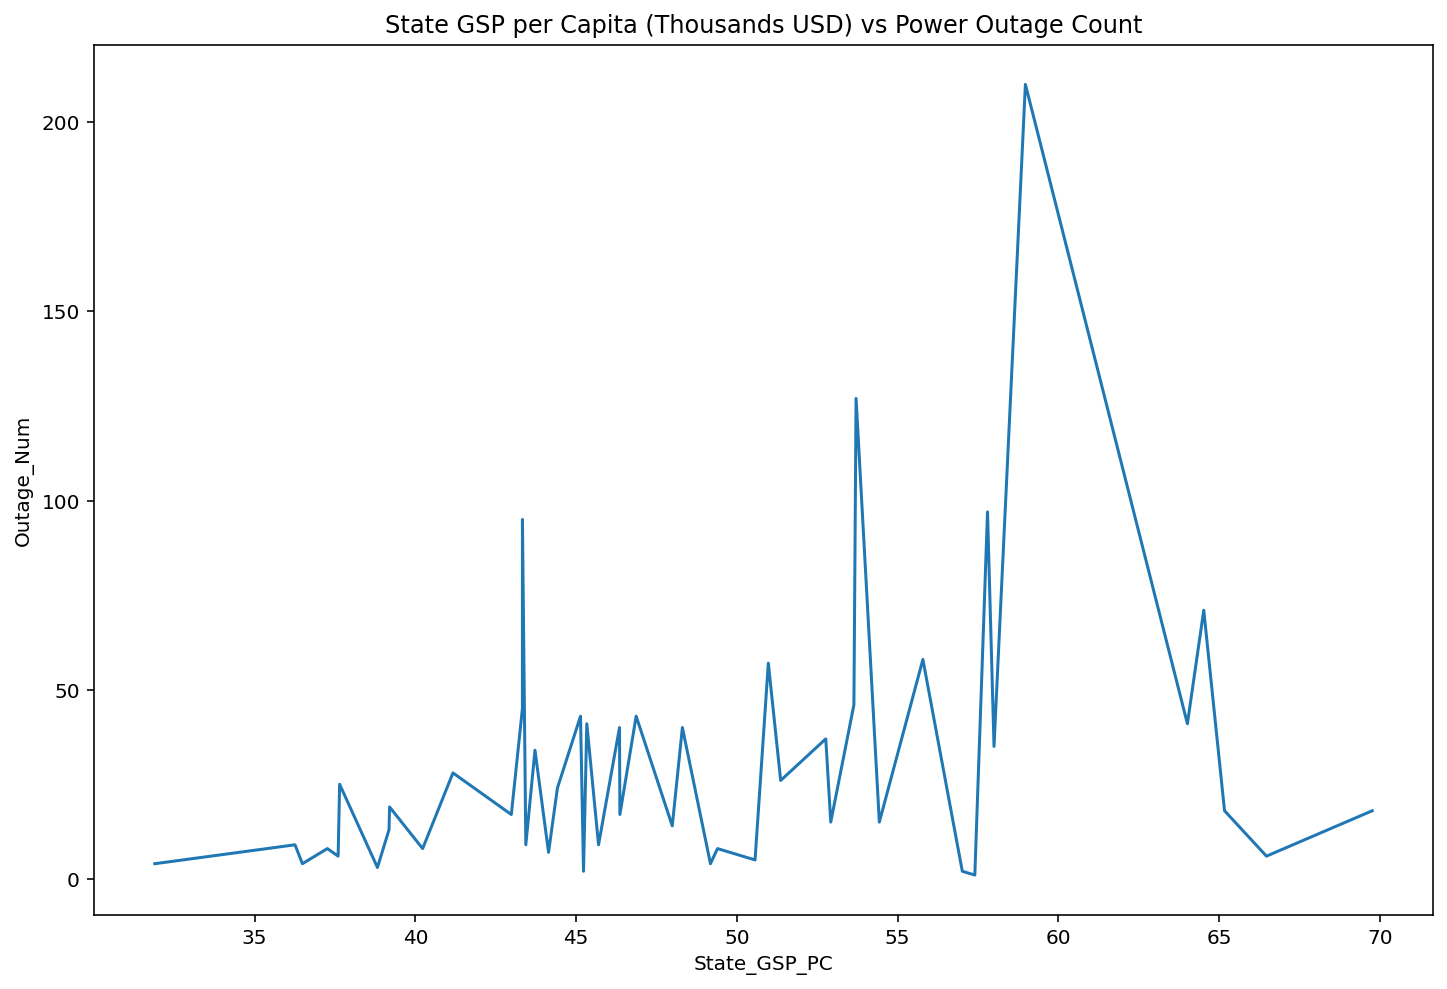

In [294]:
plt.figure(figsize=(12, 8))
sb_line = sns.lineplot(
    data=by_state,
    x= "Population",
    y="Outage_Num",
    ).set(title = "State Population (Millions) vs Power Outage Count")

plt.figure(figsize=(12, 8))
sb_line = sns.lineplot(
    data=by_state,
    x= "State_GSP_PC",
    y="Outage_Num",
    ).set(title = "State GSP per Capita (Thousands USD) vs Power Outage Count")

##### Running Regression on Population vs. Power Outage Count

In [295]:
population = by_state['Population']
outages = by_state['Outage_Num']
outcome, predictors = patsy.dmatrices('outages ~ population', by_state)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                outages   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     142.4
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           7.93e-16
Time:                        23:50:27   Log-Likelihood:                -212.35
No. Observations:                  49   AIC:                             428.7
Df Residuals:                      47   BIC:                             432.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0832      3.627      0.574      0.5

Note: R-Squared is High

### Assessment of Missingness

In [296]:

missing_pcts = {}
for column in outage.columns:
    missing_pcts[column] = outage[column].isna().sum()/outage.shape[0]

missing_cols = [k for k,v in missing_pcts.items() if v>0]

pd.DataFrame(
    data = missing_pcts.values(),
    index= missing_pcts.keys(),
    columns=['']
            )

,
YEAR,0.000000
MONTH,0.005867
POSTAL.CODE,0.000000
NERC.REGION,0.000000
CLIMATE.REGION,0.003911
ANOMALY.LEVEL,0.005867
CLIMATE.CATEGORY,0.005867
OUTAGE.START,0.005867
OUTAGE.RESTORATION,0.037810
OUTAGE.DURATION,0.037810


In [297]:
from scipy.stats import ks_2samp

cols_for_ks = [
        'YEAR', 
        'MONTH',
        'ANOMALY.LEVEL',
        'OUTAGE.DURATION',
        'DEMAND.LOSS.MW',
        'CUSTOMERS.AFFECTED',
        'PC.REALGSP.REL',
        'POPULATION'
        ]

out = pd.Series(index=cols_for_ks, dtype= np.float64)

for column in cols_for_ks:
    t = outage[column]
    t2 = outage[column].dropna()
    out[column] = ks_2samp(t,t2).pvalue

print()
pd.DataFrame(out, columns=['P Values'])


,P Values
YEAR,1.000000e+00
MONTH,1.000000e+00
ANOMALY.LEVEL,1.000000e+00
OUTAGE.DURATION,2.245021e-01
DEMAND.LOSS.MW,3.248348e-103
CUSTOMERS.AFFECTED,2.264228e-47
PC.REALGSP.REL,1.000000e+00
POPULATION,1.000000e+00


In [298]:
from scipy.stats import pearsonr

col_names = outage.columns

missing_mat = outage.apply(pd.isna)*1


missing_mat[missing_cols]

missingnessdf = pd.DataFrame(index= missing_cols, columns= missing_cols)

for col1 in missing_cols:
    for col2 in missing_cols:
        if col1 != col2:
            missingnessdf.loc[col1, col2] = (pearsonr(np.array(missing_mat[col1]),np.array(missing_mat[col2])))[1]
print('P Values for Missing Columns vs Missing Columns')
missingnessdf

P Values for Missing Columns vs Missing Columns


,MONTH,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED
MONTH,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.446255,0.658787
CLIMATE.REGION,0.0,NaN,0.0,0.0,0.0,0.097426,0.097426,0.023614,0.117988
ANOMALY.LEVEL,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.446255,0.658787
CLIMATE.CATEGORY,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.446255,0.658787
OUTAGE.START,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.446255,0.658787
OUTAGE.RESTORATION,0.0,0.097426,0.0,0.0,0.0,NaN,0.0,0.088478,0.064939
OUTAGE.DURATION,0.0,0.097426,0.0,0.0,0.0,0.0,NaN,0.088478,0.064939
DEMAND.LOSS.MW,0.446255,0.023614,0.446255,0.446255,0.446255,0.088478,0.088478,NaN,0.0
CUSTOMERS.AFFECTED,0.658787,0.117988,0.658787,0.658787,0.658787,0.064939,0.064939,0.0,NaN


In [299]:
n_permutations = 10000

obs = outage[~pd.isna(outage['CLIMATE.REGION'])]['DEMAND.LOSS.MW'].mean()

sims=[]
for i in range(n_permutations):
    temp = outage.copy()
    temp['CLIMATE.REGION'] = np.random.permutation(temp['CLIMATE.REGION'])
    sim = temp[~pd.isna(temp['CLIMATE.REGION'])]['DEMAND.LOSS.MW'].mean()
    sims.append(sim)

sims = np.array(sims)

p = np.count_nonzero(sims>= obs)/n_permutations
p


0.6803

### Hypothesis Test
Null Hypothesis: Outages are evenly distributed across population percentiles
Alternative Hypothesis: Outages are not evenly distributed across population percentiles

Test Statistic: TVD

In [300]:
n_permutations = 10000

outage['POP.PTILE'] = pd.qcut(
                        outage['POPULATION'], 
                        q=10, labels=list(range(1,11))
                            )

#h0 is outages are evenly distributed across population strata
#h1 outages are not evenly distributed across population strata

obsdist = np.array(outage.groupby('POP.PTILE').count()['POSTAL.CODE']/1534)
nulldist = np.array([1]*10)/10

obs_tvd = np.sum(np.abs(obsdist-nulldist))
obs_tvd

tvds = []
for i in range(n_permutations):
    temp = outage.copy()
    temp['POP.PTILE'] = np.random.choice(np.array(list(range(1,11))), 1534)
    trialdist = np.array(temp.groupby('POP.PTILE').count()['POSTAL.CODE']/1534)
    tvd = np.sum(np.abs(trialdist-nulldist))
    tvds.append(tvd)

tvds = np.array(tvds)

p = np.count_nonzero(obs_tvd<=tvds)/n_permutations
p

0.9117